In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

In [2]:
import jax
import jax.numpy as jnp
import numpyro
from numpyro import infer

import matplotlib.pyplot as plt
import arviz as az
import corner

In [3]:
import antiglitch
from antiglitch import freqs, extract_glitch, fsignal, to_fd, glitch_model

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
if False:
    numpyro.set_host_device_count(4) # Use 4 cores if available

In [5]:
# Define Bayesian sampler
sampler = infer.MCMC(
    infer.NUTS(glitch_model),
    num_warmup=2000,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,
)

blip20, tomte0

In [35]:
ifo, key, num = ('L1', 'tomte', 0)
snip = antiglitch.Snippet(ifo, key, num)

invasd = snip.invasd
fglitch = to_fd(snip.whts)

/nfshome/store01/users/andrew.lundgren/src/antiglitch/antiglitch/utils.py:31: RuntimeWarning: divide by zero encountered in power
  invasd = ((4096.*npz['psd'])**-0.5)[:4097]


In [36]:
%time sampler.run(jax.random.PRNGKey(0), freqs[1:], invasd[1:], data=fglitch[1:])

sample: 100%|██████████| 3000/3000 [00:17<00:00, 174.15it/s, 63 steps of size 6.01e-02. acc. prob=0.94]


CPU times: user 17.6 s, sys: 95.6 ms, total: 17.6 s
Wall time: 17.5 s


In [39]:
itrace = az.from_numpyro(sampler)
summ = az.summary(itrace, kind='stats')

In [40]:
inf_data = itrace
inf = {key: float(np.mean(inf_data.posterior[key]))
        for key in ['amp_r', 'amp_i', 'f0','gbw','time']}
cpamp = inf['amp_r']+1.j*inf['amp_i']
inf['amp'] = np.abs(cpamp)
inf['phase'] = np.angle(cpamp)

In [41]:
inf

{'amp_r': -375.2820739746094,
 'amp_i': -75.01566314697266,
 'f0': 14.560467720031738,
 'gbw': 1.7155165672302246,
 'time': -0.8068641424179077,
 'amp': 382.7061336901517,
 'phase': -2.9443015087859137}

In [42]:
glitch1 = fsignal(freqs, 87.536, 0.4579)

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

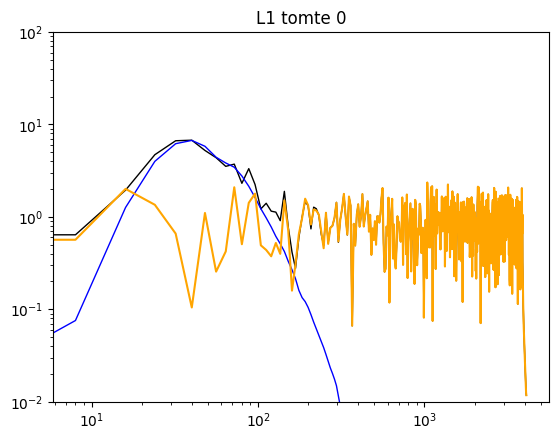

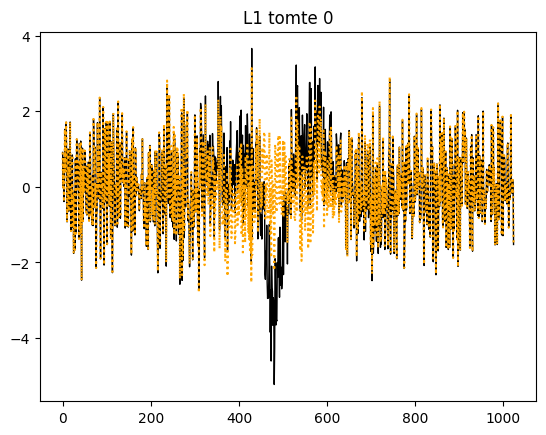

In [43]:
snip.set_infer(inf)
snip.plot()

In [30]:
print(az.summary(itrace, kind='stats'))

         mean     sd  hdi_3%  hdi_97%
amp_i  25.490  1.390  22.881   28.058
amp_r  93.855  1.666  90.785   96.900
f0     87.536  5.908  75.730   97.663
gbw     0.458  0.028   0.409    0.516
time   -0.781  0.000  -0.781   -0.781


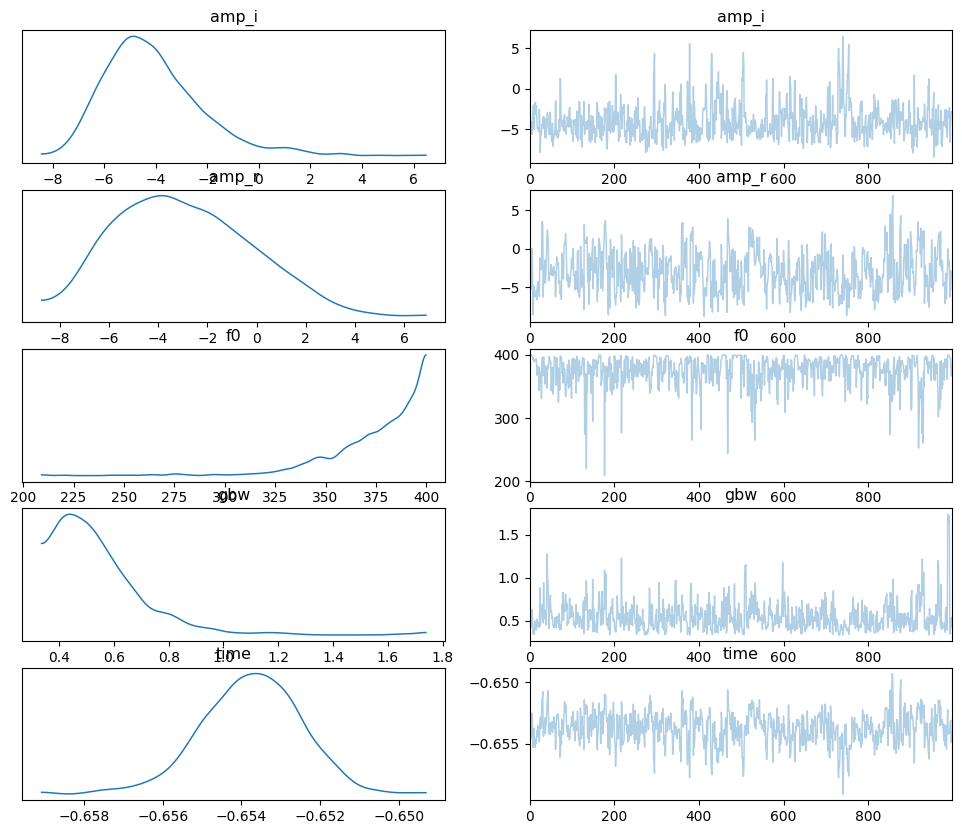

In [51]:
az.plot_trace(itrace);

In [13]:
# An attempt at finding the MAP

num_svi_steps = 2000
from numpyro.infer import SVI, Trace_ELBO, autoguide
optimizer = numpyro.optim.Adam(step_size=1e-3)
guide = autoguide.AutoDelta(glitch_model)
svi = SVI(glitch_model, guide, optimizer, loss=Trace_ELBO())
svi_result = svi.run(jax.random.PRNGKey(0), num_svi_steps, freqs[1:], invasd[1:], data=fglitch[1:])
params, losses = svi_result.params, svi_result.losses

100%|██████████| 2000/2000 [00:01<00:00, 1047.41it/s, init loss: 4112.2671, avg. loss [1901-2000]: 1895.7081]


In [4]:
jax.__file__

'/home/andrew.lundgren/.conda/envs/jax/lib/python3.9/site-packages/jax/__init__.py'